Running RAG Pipeline Locally. This notebook is inspired by https://github.com/mrdbourke/simple-local-rag

In [1]:
# Importing Relevant Libraries
import os
import re
import random

import numpy as np
import pandas as pd
import torch
import spacy
import en_core_web_trf 

from sentence_transformers import util, SentenceTransformer

import fitz
from tqdm import tqdm

C:\Prateek\Projects\RAG Projects\rag\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# All Functions
def remove_new_line(text: str) -> str:
    """
    Remove new line from the pdf text
    """
    new_text = text.replace("\n", " ")
    return new_text

In [3]:
doc = fitz.open("samples\Human-Nutrition-2020-Edition.pdf")

<>:1: SyntaxWarning: invalid escape sequence '\H'
<>:1: SyntaxWarning: invalid escape sequence '\H'
C:\Users\prate\AppData\Local\Temp\ipykernel_22744\2226369792.py:1: SyntaxWarning: invalid escape sequence '\H'
  doc = fitz.open("samples\Human-Nutrition-2020-Edition.pdf")


In [4]:
pages_and_texts = []

In [5]:
for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text()
    text = remove_new_line(text)
    pages_and_texts.append({"page_number": page_number+1,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    # return pages_and_texts

1208it [00:01, 1127.88it/s]


In [6]:
# Check Random Samples
# random.sample(pages_and_texts, k=2)

In [7]:
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,1,31,6,1,7.75,Human Nutrition: 2020 Edition
1,2,0,1,1,0.00,
2,3,322,56,1,80.50,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,4,214,34,2,53.50,Human Nutrition: 2020 Edition by University of...
4,5,799,147,2,199.75,Contents Preface University of Hawai‘i at Mā...


In [8]:
# Get stats summary
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,604.50,1149.01,199.30,9.97,287.25
std,348.86,560.41,95.79,6.19,140.10
min,1.00,0.00,1.00,1.00,0.00
25%,302.75,763.00,135.00,4.00,190.75
50%,604.50,1232.50,215.50,10.00,308.12
75%,906.25,1604.50,272.00,14.00,401.12
max,1208.00,2309.00,430.00,32.00,577.25


In [9]:
# Using spacy for english language
# Model(en_core_web_trf) is selected for accuracy rather than performance

nlp = spacy.load("en_core_web_trf")
nlp = en_core_web_trf.load()
doc = nlp("This is a sentence. Here's another one. Another one by DJ Khalid")

C:\Prateek\Projects\RAG Projects\rag\Lib\site-packages\thinc\shims\pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filelike, m

In [10]:
print(list(doc.sents))

[This is a sentence., Here's another one., Another one by DJ Khalid]


In [11]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    # Count the sentences 
    item["page_sentence_count_spacy"] = len(item["sentences"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1208/1208 [03:49<00:00,  5.27it/s]


In [12]:
# Inspect an example
# random.sample(pages_and_texts, k=1)

In [13]:
# Updated DataFrame
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,604.50,1149.01,199.30,9.97,287.25,13.26
std,348.86,560.41,95.79,6.19,140.10,7.02
min,1.00,0.00,1.00,1.00,0.00,0.00
25%,302.75,763.00,135.00,4.00,190.75,8.00
50%,604.50,1232.50,215.50,10.00,308.12,13.50
75%,906.25,1604.50,272.00,14.00,401.12,19.00
max,1208.00,2309.00,430.00,32.00,577.25,35.00


In [14]:
# Define split size to turn groups of sentences into chunks
chunk_size = 10 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1208/1208 [00:00<00:00, 603683.93it/s]


In [15]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
# random.sample(pages_and_texts, k=1)

In [16]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,604.50,1149.01,199.30,9.97,287.25,13.26,1.76
std,348.86,560.41,95.79,6.19,140.10,7.02,0.75
min,1.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,302.75,763.00,135.00,4.00,190.75,8.00,1.00
50%,604.50,1232.50,215.50,10.00,308.12,13.50,2.00
75%,906.25,1604.50,272.00,14.00,401.12,19.00,2.00
max,1208.00,2309.00,430.00,32.00,577.25,35.00,4.00


In [17]:
# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1208/1208 [00:00<00:00, 44736.87it/s]


2127

In [18]:
df = pd.DataFrame(pages_and_chunks)
df.head().T

,0,1,2,3,4
page_number,1,3,4,5,6
sentence_chunk,Human Nutrition: 2020 Edition,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,Human Nutrition: 2020 Edition by University of...,Contents Preface University of Hawai‘i at Māno...,Lifestyles and Nutrition University of Hawai‘i...
chunk_char_count,29,308,210,766,941
chunk_word_count,4,42,30,114,142
chunk_token_count,7.25,77.0,52.5,191.5,235.25


In [19]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 762,
  'sentence_chunk': 'crackers equals one serving and that the whole box contains 10 servings. All other values listed thereafter, from the calories to the dietary fiber, are based on this one serving. On the panel, the serving size is followed by the number of calories and then a list of selected nutrients. You will also see “Percent Daily Value” on the far right-hand side. This helps you determine if the food is a good source of a particular nutrient or not. The Daily Value (DV) represents the recommended amount of a given nutrient based on the RDA of that nutrient in a 2,000-kilocalorie diet. The DV was updated as part of the new nutrition facts label announced in May 2016. The updated DV applies to packaged food, beverages and dietary supplements that contain ingredients with a DV.',
  'chunk_char_count': 774,
  'chunk_word_count': 135,
  'chunk_token_count': 193.5}]

In [20]:
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,2127.00,2127.00,2127.00,2127.00
mean,628.22,635.96,97.05,158.99
std,347.73,376.76,59.55,94.19
min,1.00,3.00,1.00,0.75
25%,324.50,315.50,45.00,78.88
50%,630.00,661.00,101.00,165.25
75%,937.50,912.50,142.00,228.12
max,1208.00,1830.00,296.00,457.50


In [21]:
# Show random chunks with under 30 tokens in length
min_token_length = 18
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 10.25 | Text: Accessed September 22, 2017. 178 | Sodium
Chunk token count: 16.5 | Text: PART X CHAPTER 10. MAJOR MINERALS Chapter 10. Major Minerals | 607
Chunk token count: 16.0 | Text: PART II CHAPTER 2. THE HUMAN BODY Chapter 2. The Human Body | 53
Chunk token count: 16.25 | Text: Health Consequences and Benefits of High-Carbohydrate Diets | 261
Chunk token count: 18.0 | Text: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=364   630 | Calcium


In [22]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': 3,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': 4,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [23]:
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", ) 


# # Uncomment to see how long it takes to create embeddings on CPU
# # # Make sure the model is on the CPU
# embedding_model.to("cpu")

# # # Embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

C:\Prateek\Projects\RAG Projects\rag\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
# %%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1976/1976 [00:21<00:00, 93.94it/s]


In [25]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [26]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: total: 38 s
Wall time: 14.5 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0632,  0.0064, -0.0105,  ..., -0.0473, -0.0742, -0.0287],
        [ 0.1215,  0.0164,  0.0090,  ..., -0.0486, -0.0511, -0.0271],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [42]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [43]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,3,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281627e-02 -5.09548746e-...
1,4,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139475e-02 -1.66167263e-...
2,5,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801954e-02 3.39813977e-02 -2.06426475e-...
3,6,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566985e-02 3.81274857e-02 -8.46854411e-...
4,7,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264606e-02 -8.49768985e-03 9.57160164e-...


In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1976, 768])

In [45]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,3,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281627, -0.00509548746, -..."
1,4,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139475, -0.0166167263, -0..."
2,5,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801954, 0.0339813977, -0.0206426475, 0...."
3,6,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566985, 0.0381274857, -0.00846854411, -..."
4,7,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264606, -0.00849768985, 0.00957160164, ..."


In [46]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1666e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7765e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0476e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1001e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6136e-02,
         1.7951e-03,  5.2593e-02, -3.3175e-03, -8.3387e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4902e-04, -9.9662e-02,  4.9

In [47]:
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device)

C:\Prateek\Projects\RAG Projects\rag\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [48]:
# 1. Define the query
query = "What are the macronutrient?"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: What are the macronutrient?
Time take to get scores on 1976 embeddings: 0.00025 seconds.


torch.return_types.topk(
values=tensor([0.7579, 0.7137, 0.6178, 0.6096, 0.6034], device='cuda:0'),
indices=tensor([  44,   51,   50, 1027,   53], device='cuda:0'))

In [49]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([197600, 768])
Time take to get scores on 197600 embeddings: 0.00024 seconds.


In [50]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [51]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'What are the macronutrient?'

Results:
Score: 0.7579
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processedinto cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energyis the calorie.
Page number: 47


Score: 0.7137
Text:
Figure 1.1 The Macronutrients: Carbohydrates, Lipids, Protein, and Water
Introduction | 7
Page number: 49


Score: 0.6178
Text:
Figure 1.1The Macronutrie nts: Carbohydrat es, Lipids, Protein, and Water
Proteins Proteins are macromolecules composed of chains of subunits called amino
acids. Amino acids are simple subunits composed of carbon, oxygen, hydrogen, and
nitrogen. Food sources of proteins include m

<>:4: SyntaxWarning: invalid escape sequence '\H'
<>:4: SyntaxWarning: invalid escape sequence '\H'
C:\Users\prate\AppData\Local\Temp\ipykernel_22744\1967772766.py:4: SyntaxWarning: invalid escape sequence '\H'
  pdf_path = "samples\Human-Nutrition-2020-Edition.pdf" # requires PDF to be downloaded


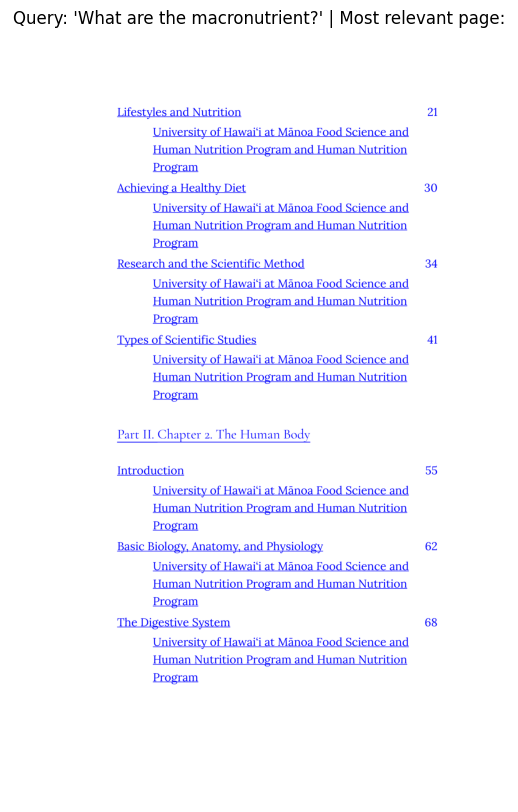

In [52]:
import fitz

# Open PDF and load target page
pdf_path = "samples\Human-Nutrition-2020-Edition.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [53]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [54]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [55]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 8 GB


In [56]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

# use_quantization_config = True
# model_id = "google/flan-t5-base"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 8 | Recommended model: Gemma 2B in 4-bit precision.
use_quantization_config set to: True
model_id set to: google/gemma-2b-it


In [57]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
from transformers import BitsAndBytesConfig

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)

quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention 
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model) 
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, 
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                  device_map="auto",
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=True, # use full memory 
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU 
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [59]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): G

In [60]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

1515268096

In [61]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 2039641088, 'model_mem_mb': 1945.15, 'model_mem_gb': 1.9}

In [62]:
input_text = "What are the macronutrients|?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients|?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients|?<end_of_turn>
<start_of_turn>model



In [63]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig 
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235371, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}



C:\Prateek\Projects\RAG Projects\rag\Lib\site-packages\transformers\models\gemma\modeling_gemma.py:374: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235371, 235336,    107,    108,    106,   2516,    108,  21404,
        235269,   1517, 235303, 235256,    476,  25497,    576,    573, 186809,
        184592, 235292,    109,    688,  12298,   1695, 184592,    688,    708,
         37132,    674,    573,   2971,   4026,    575,   2910,  15992,    577,
         10528,   1426,   2962, 235265,   2365,    708,   8727,    604,   4282,
         55786,   7257, 235269,   3359, 235292,    109, 235287,   5231, 156615,
         56227,  66058,  34428,   4134,    604,    573,   2971, 235303, 235256,
          5999,    578,  29703, 235265,    108, 235287,   5231,  49471,  66058,
         64783,   2500,    578,  12158,  29703, 235269,   7872,  44760, 235269,
           578,   7872,  53186, 235265,    108, 235287,   5231,  33690,  66058,
         64783,  33398,  48765,    578,  31740, 235269,   2029,   7459,    573,
          2971, 2

In [64]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients|?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients:

**Macronutrients** are nutrients that the body needs in large amounts to maintain good health. They are essential for various bodily functions, including:

* **Carbohydrates:** Provide energy for the body's cells and tissues.
* **Protein:** Helps build and repair tissues, produce enzymes, and produce hormones.
* **Fat:** Helps absorb vitamins and minerals, insulate the body, and produce hormones.

There are three main macronutrients:

* **Carbohydrates:** Found in foods like bread, pasta, rice, and fruits.
* **Protein:** Found in foods like meat, fish, eggs, legumes, and nuts.
* **Fat:** Found in foods like olive oil, coconut oil, nuts, and seeds.

It's important to consume a balanced diet that includes all three macronutrients in order to maintain overall health and well-being.<eos>



In [65]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the macronutrients|?

Output text:
Sure, here's a breakdown of the macronutrients:

**Macronutrients** are nutrients that the body needs in large amounts to maintain good health. They are essential for various bodily functions, including:

* **Carbohydrates:** Provide energy for the body's cells and tissues.
* **Protein:** Helps build and repair tissues, produce enzymes, and produce hormones.
* **Fat:** Helps absorb vitamins and minerals, insulate the body, and produce hormones.

There are three main macronutrients:

* **Carbohydrates:** Found in foods like bread, pasta, rice, and fruits.
* **Protein:** Found in foods like meat, fish, eggs, legumes, and nuts.
* **Fat:** Found in foods like olive oil, coconut oil, nuts, and seeds.

It's important to consume a balanced diet that includes all three macronutrients in order to maintain overall health and well-being.


In [66]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [67]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: How do vitamins and minerals differ in their roles and importance for health?
[INFO] Time taken to get scores on 1976 embeddings: 0.00006 seconds.


(tensor([0.6856, 0.6325, 0.6225, 0.6137, 0.6091], device='cuda:0'),
 tensor([  53,   56, 1029, 1091,   54], device='cuda:0'))

In [68]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [69]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
    
# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: water soluble vitamins
[INFO] Time taken to get scores on 1976 embeddings: 0.00006 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism

In [70]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt 

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: water soluble vitamins
RAG answer:
<bos>Sure, here's the relevant passage from the context:

> Vitamins and minerals that make up part of enzymes are referred to as coenzymes and cofactors, respectively. Coenzymes and cofactors are required by enzymes to catalyze a specific reaction. They assist in converting a substrate to an end-product. Coenzymes and cofactors play a role in many anabolic pathways too.<eos>
CPU times: total: 531 ms
Wall time: 3.16 s


In [71]:
def ask(query, 
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU 
        
    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [72]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context 
answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: How do vitamins and minerals differ in their roles and importance for health?
[INFO] Time taken to get scores on 1976 embeddings: 0.00007 seconds.
Answer:

Sure, here's the answer:  **Vitamins** are essential for the body to obtain
energy and perform various essential functions. They play a vital role in
metabolism, including supporting enzymes that facilitate chemical reactions in
the body, regulating blood sugar levels, and supporting immune function.
Vitamins help maintain the health of the body's cells and tissues, supporting
various bodily functions.  **Minerals** are vital for maintaining various bodily
functions and are obtained through various sources in our diet. These minerals,
including calcium, magnesium, potassium, sodium, and vitamin B-complex (B
vitamins), play crucial roles in maintaining bone and teeth health, nerve
transmission, muscle contraction, and blood clotting.
Context items:


[{'page_number': 50,
  'sentence_chunk': 'There are sixteen essential minerals and thirteen vitamins (See Table 1.1 “Minerals and Their Major Functions” and Table 1.2 “Vitamins and Their Major Functions” for a complete list and their major functions). In contrast to carbohydrates, lipids, and proteins, micronutrients are not sources of energy (calories), but they assist in the process as cofactors or components of enzymes (i.e., coenzymes). Enzymes are proteins that catalyze chemical reactions in the body and are involved in all aspects of body functions from producing energy, to digesting nutrients, to building macromolecules. Micronutrients play many essential roles in the body. Table 1.1 Minerals and Their Major Functions 8 | Introduction',
  'chunk_char_count': 709,
  'chunk_word_count': 106,
  'chunk_token_count': 177.25,
  'embedding': array([ 3.86236459e-02, -3.75576727e-02,  1.41006938e-04,  4.60188463e-02,
          5.52852117e-02,  5.72770350e-02, -5.51103354e-02,  1.78304054